In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

In [2]:
train_df = pd.read_json("train.json").reset_index(drop=True)
test_df = pd.read_json("test.json").reset_index(drop=True)
train_df['test'] = False
test_df['test'] = True

cdf = train_df.append(test_df).reset_index(drop=True)
cdf.shape

(124011, 16)

In [3]:
cdf.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,124011.000000,124011.000000,124011.000000,1.240110e+05,124011.000000,1.240110e+05
mean,1.212622,1.543460,40.737641,7.024022e+06,-73.949434,3.781324e+03
std,0.595209,1.110203,0.744337,1.263795e+05,1.372882,1.582988e+04
min,0.000000,0.000000,0.000000,6.811957e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.728000,6.915638e+06,-73.991700,2.495000e+03
50%,1.000000,1.000000,40.751700,7.021451e+06,-73.977800,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129028e+06,-73.954700,4.100000e+03
max,112.000000,8.000000,44.883500,7.761779e+06,0.000000,4.490000e+06


Before proceeding forward:
- Clean the data
- Remove any outliers
- Perform exploratory data analysis to understand the data.

### Feature engineering
Compute additional features:

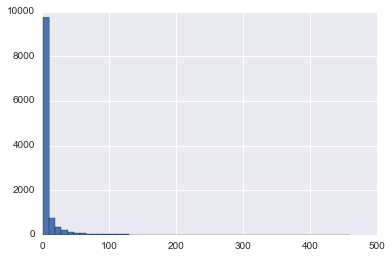

In [4]:
bldg_id_counts = cdf.building_id.value_counts()
plt.hist(bldg_id_counts[bldg_id_counts < 500], bins=50)
plt.show()

In [5]:
cdf['words_in_description'] = cdf.description.map(lambda d: len(d.split()))
cdf['listings_in_bldg'] = cdf.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)
cdf['num_photos'] = cdf.photos.map(len)
cdf['created'] = pd.to_datetime(cdf['created'])
cdf['created_month'] = cdf.created.map(lambda dt: dt.month)
cdf['created_day'] = cdf.created.map(lambda dt: dt.dayofweek)

### One-hot encoding of categorical features

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
cdf['created_month'] = le.fit_transform(cdf['created_month'])

In [7]:
ohe = OneHotEncoder()
encoded = ohe.fit_transform(cdf.created_month.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['month_is_4', 'month_is_5', 'month_is_6'])
cdf = cdf.merge(encoded, left_index=True, right_index=True)

In [8]:
encoded = ohe.fit_transform(cdf.created_day.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['day_is_' + str(i) for i in range(7)])
cdf = cdf.merge(encoded, left_index=True, right_index=True)

cdf.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,month_is_4,month_is_5,month_is_6,day_is_0,day_is_1,day_is_2,day_is_3,day_is_4,day_is_5,day_is_6
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
cdf.drop(['created_month', 'created_day', 'month_is_4', 'day_is_0'], axis=1, inplace=True)
cdf.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,listings_in_bldg,num_photos,month_is_5,month_is_6,day_is_1,day_is_2,day_is_3,day_is_4,day_is_5,day_is_6
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,5,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,51,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,131,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Using the 'Description' column

In [10]:
from nltk.stem import PorterStemmer
import re

In [11]:
stemmer = PorterStemmer()

def process_desc(x):
    regex = re.compile('[^a-zA-Z ]')
    desc = regex.sub(' ', x).lower().split(" ") 
    desc = [stemmer.stem(l) for l in desc]
    desc = " ".join([l.strip() for l in desc])
    return desc

In [12]:
cdf['description_clean'] = cdf.description.apply(process_desc)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(stop_words='english', max_features=200)
desc_messages = bow_transformer.fit_transform(cdf.description_clean)
col_desc = ['desc_'+ i for i in bow_transformer.get_feature_names()] 
desc_df = pd.DataFrame(desc_messages.todense(), columns=col_desc)
cdf_desc = pd.concat([cdf.reset_index(), desc_df], axis=1)

In [14]:
desc_df.head()

,desc_access,desc_allow,desc_amaz,desc_amen,desc_ani,desc_apart,desc_applianc,desc_appoint,desc_area,desc_art,...,desc_villag,desc_walk,desc_wall,desc_washer,desc_water,desc_websit,desc_west,desc_window,desc_wood,desc_york
0,0,0,0,0,0,2,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,2,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
3,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,3,1,1,0,0,...,0,0,2,1,0,0,0,0,1,0


In [15]:
desc_df.shape

(124011, 200)

In [16]:
print(len(bow_transformer.vocabulary_))

200


You can repeat the same steps to process the text in the 'features' column.

#### You could then weight and normalize the terms using TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(desc_messages)
desc_tfidf = tfidf_transformer.transform(desc_messages)
print(desc_tfidf.shape)

(124011, 200)


You can then train a classifier using the description features, using say the Naive Bayes classifier algorithm.

In [18]:
cdf = pd.concat([cdf, desc_df], axis=1)

### Split dataset into train and test

In [19]:
features_to_drop = [ 'building_id',
                     'created',
                     'description',
                     'display_address',
                     'features',
                     'manager_id',
                     'photos',
                     'street_address',
                     'description_clean']
cdf.drop(features_to_drop, axis=1, inplace=True)
cdf.head(3)

,bathrooms,bedrooms,interest_level,latitude,listing_id,longitude,price,test,words_in_description,listings_in_bldg,...,desc_villag,desc_walk,desc_wall,desc_washer,desc_water,desc_websit,desc_west,desc_window,desc_wood,desc_york
0,1.5,3,medium,40.7145,7211212,-73.9425,3000,False,93,5,...,0,0,0,1,0,1,0,0,0,0
1,1.0,2,low,40.7947,7150865,-73.9667,5465,False,0,51,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,high,40.7388,6887163,-74.0018,2850,False,92,131,...,1,0,0,0,0,1,1,0,0,1


In [20]:
df = cdf[cdf.test == False]
tdf = cdf[cdf.test == True]

In [21]:
X = df.drop(['interest_level', 'listing_id', 'test'], axis=1).copy()
y = df.interest_level.copy()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test_onehot = pd.get_dummies(y_test)
y_test_onehot.head()

,high,low,medium
10335,0.0,1.0,0.0
41980,0.0,1.0,0.0
12872,0.0,1.0,0.0
48283,0.0,1.0,0.0
10593,0.0,1.0,0.0


In [23]:
df.shape, tdf.shape

((49352, 219), (74659, 219))

### Train the model
Using Logistic Regression Classification as an example:

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [25]:
reg = LogisticRegressionCV(cv=3, multi_class='multinomial', verbose=2, scoring='accuracy', max_iter=5000)
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=2)

#### Evaluate the model

In [26]:
from sklearn.metrics import log_loss, accuracy_score

y_pred = reg.predict(X_test)
y_prob = pd.DataFrame(data=reg.predict_proba(X_test), columns=reg.classes_)
y_prob.reindex_axis(labels=['high', 'medium', 'low'])

print("Accuracy = ", accuracy_score(y_test, y_pred))
print("Log-loss = ", log_loss(y_test_onehot, y_prob))

Accuracy =  0.697555045252
Log-loss =  0.697231324233


### Now try another model: Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=1, warm_start=False)

In [28]:
from sklearn.metrics import log_loss, accuracy_score

y_pred = rfc.predict(X_test)
y_prob = pd.DataFrame(data=rfc.predict_proba(X_test), columns=rfc.classes_)
y_prob.reindex_axis(labels=['high', 'medium', 'low'])

print("Accuracy = ", accuracy_score(y_test, y_pred))
print("Log-loss = ", log_loss(y_test_onehot, y_prob))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy =  0.698365527489
Log-loss =  0.694896436582


### Tuning model parameters using grid-search

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# List the different parameters that you want to tune
grid_search_params = dict(n_estimators=[100,1000], 
                          max_depth=[None,10,20], 
                          class_weight=[None, 'balanced'])
rfc = RandomForestClassifier()
gs = GridSearchCV(estimator=rfc, param_grid=grid_search_params, n_jobs=3, verbose=10)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  9.4min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 12.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'class_weight': [None, 'balanced'], 'max_depth': [None, 10, 20], 'n_estimators': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [30]:
print("Best params: ", gs.best_params_)
print("Best score: ", gs.best_score_)

Best params:  {'class_weight': None, 'max_depth': None, 'n_estimators': 1000}
Best score:  0.711399293695


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = gs.predict(X_test)

print(classification_report(y_test, y_pred))
classes = gs.best_estimator_.classes_
pd.DataFrame( confusion_matrix(y_test, y_pred), 
              index= ['true_'+classes[i] for i in range(len(classes))],
              columns= ['pred_'+classes[i] for i in range(len(classes))] )

             precision    recall  f1-score   support

       high       0.46      0.14      0.22      1183
        low       0.75      0.95      0.84     10285
     medium       0.47      0.20      0.28      3338

avg / total       0.66      0.72      0.66     14806



,pred_high,pred_low,pred_medium
true_high,171,720,292
true_low,49,9751,485
true_medium,149,2509,680


### Predict target interest level

In [32]:
train_features = X_train.columns
train_features

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'words_in_description', 'listings_in_bldg', 'num_photos', 'month_is_5',
       'month_is_6',
       ...
       'desc_villag', 'desc_walk', 'desc_wall', 'desc_washer', 'desc_water',
       'desc_websit', 'desc_west', 'desc_window', 'desc_wood', 'desc_york'],
      dtype='object', length=216)

In [33]:
X_target = tdf[train_features].copy()
target_listing_ids = tdf['listing_id'].values
X_target.shape

(74659, 216)

In [34]:
target_prob = pd.DataFrame(data=gs.predict_proba(X_target), columns=gs.best_estimator_.classes_)

#### Add listing ID to the target dataframe

In [35]:
target_prob['listing_id'] = target_listing_ids
target_prob = target_prob.reindex_axis(labels=['listing_id', 'high', 'medium', 'low'], axis=1)

In [36]:
target_prob.head()

,listing_id,high,medium,low
0,7142618,0.081000,0.339367,0.579633
1,7210040,0.078000,0.136600,0.785400
2,7103890,0.089000,0.290167,0.620833
3,7143442,0.095333,0.345467,0.559200
4,6860601,0.025000,0.187000,0.788000


#### Write results to file for submission

First check that the predictions dataframe is the right size.

In [37]:
target_prob.shape

(74659, 4)

In [38]:
target_prob.to_csv("rf1.csv", index=False)

You can now upload this file on the Kaggle submissions page.